<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [54]:
import os
from pathlib import Path
import shutil

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from cifar import load_cifar10
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Using device: cuda


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [6]:
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-06-05 20:30:44--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.


OpenSSL: error:0A000126:SSL routines::unexpected eof while reading
Unable to establish SSL connection.


In [7]:
!unzip -qq images_background.zip -d images_background_extracted
!unzip -qq images_evaluation.zip -d images_evaluation_extracted

In [8]:
if os.path.exists('images_background_extracted/images_background'):
    shutil.move('images_background_extracted/images_background', '.')
    shutil.rmtree('images_background_extracted')
if os.path.exists('images_evaluation_extracted/images_evaluation'):
    shutil.move('images_evaluation_extracted/images_evaluation', '.')
    shutil.rmtree('images_evaluation_extracted')

print("Data download and extraction complete.")

Data download and extraction complete.


## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [9]:
def read_alphabets(alphabet_directory_path, augment_with_rotations=True):
    """
    Reads all the characters from a given alphabet_directory.
    Each character's images can be augmented with rotations, treating each rotation as a new class.
    Args:
      alphabet_directory_path (str): path to directory with character folders (e.g., images_background/Alphabet_of_the_Magi)
      augment_with_rotations (bool): If True, creates 4 classes per original character (0, 90, 180, 270 deg rotations)
    Returns:
      datax (list): list of path names of images (or tuples of (path, rotation_angle))
      datay (list): list of labels (class names)
    """
    datax = []  # all file names of images (or path, rotation tuples)
    datay = []  # all class names
    
    alphabet_name = Path(alphabet_directory_path).name

    for character_folder in sorted(os.listdir(alphabet_directory_path)):
        character_path = os.path.join(alphabet_directory_path, character_folder)
        if not os.path.isdir(character_path):
            continue

        original_class_label = f"{alphabet_name}_{character_folder}"
        
        image_files = [os.path.join(character_path, img_file) for img_file in sorted(os.listdir(character_path))]

        if augment_with_rotations:
            rotations = [0, 90, 180, 270]
            for rot_idx, angle in enumerate(rotations):
                rotated_class_label = f"{original_class_label}_rot{angle}"
                for img_file in image_files:
                    datax.append((img_file, angle))
                    datay.append(rotated_class_label)
        else:
            for img_file in image_files:
                datax.append((img_file, 0))
                datay.append(original_class_label)
                
    return datax, datay

In [17]:
def read_images(base_directory, augment_with_rotations=True):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically (not implemented here for simplicity)
    """
    datax_all = []
    datay_all = []
    
    print(f"Reading images from {base_directory}...")
    alphabet_folders = [d for d in sorted(os.listdir(base_directory)) if os.path.isdir(os.path.join(base_directory, d))]

    for alphabet_dir_name in tqdm(alphabet_folders, desc=f"Processing alphabets in {base_directory}"):
        alphabet_path = os.path.join(base_directory, alphabet_dir_name)
        datax_alphabet, datay_alphabet = read_alphabets(alphabet_path, augment_with_rotations)
        datax_all.extend(datax_alphabet)
        datay_all.extend(datay_alphabet)
        
    return np.array(datax_all, dtype=object), np.array(datay_all)

In [21]:
trainx_meta, trainy = read_images('images_background', augment_with_rotations=True)

Reading images from images_background...






Processing alphabets in images_background: 100%|██████████| 30/30 [00:00<00:00, 452.24it/s]


In [22]:
testx_meta, testy = read_images('images_evaluation', augment_with_rotations=True)

Reading images from images_evaluation...






Processing alphabets in images_evaluation: 100%|██████████| 20/20 [00:00<00:00, 403.57it/s]


In [23]:
trainx_meta.shape, trainy.shape, testx_meta.shape, testy.shape

((77120, 2), (77120,), (52720, 2), (52720,))

In [24]:
print(f"Train samples: {trainx_meta.shape}, Unique train classes: {len(np.unique(trainy))}")
print(f"Test samples: {testx_meta.shape}, Unique test classes: {len(np.unique(testy))}")

Train samples: (77120, 2), Unique train classes: 3856
Test samples: (52720, 2), Unique test classes: 2636


In [25]:
train_base_labels = set([label.split('_rot')[0] for label in trainy])
test_base_labels = set([label.split('_rot')[0] for label in testy])
assert len(train_base_labels.intersection(test_base_labels)) == 0, "Overlap in base characters between train and test!"

all_labels = np.concatenate([trainy, testy])
unique_labels, _ = np.unique(all_labels, return_inverse=True)
label_to_id = {label: i for i, label in enumerate(unique_labels)}

trainy_ids = np.array([label_to_id[label] for label in trainy])
testy_ids = np.array([label_to_id[label] for label in testy])

## Create samples

In [27]:
def rotate_image(image, angle):
    if angle == 0:
        return image
    elif angle == 90:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return image

In [28]:
def extract_sample(n_way, n_support, n_query, datax_meta, datay_ids):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax_meta (np.array): dataset of (image_path, rotation_angle) tuples
      datay_ids (np.array): dataset of integer labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, C, H, W)
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K_classes_ids = np.random.choice(np.unique(datay_ids), n_way, replace=False)
    
    for cls_id in K_classes_ids:
        datax_cls_meta = datax_meta[datay_ids == cls_id]
        
        perm_indices = np.random.permutation(len(datax_cls_meta))
        
        sample_cls_meta = datax_cls_meta[perm_indices[:(n_support + n_query)]]
        
        class_images = []
        for (fname, angle) in sample_cls_meta:
            img = cv2.imread(fname)
            if img is None:
                print(f"Warning: Could not read image {fname}")
                img = np.zeros((28, 28, 3), dtype=np.uint8)
            else:
                img = rotate_image(img, angle)
                img = cv2.resize(img, (28, 28))
            
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 1:
                 img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            class_images.append(img)
        sample.append(class_images)
        
    sample = np.array(sample, dtype=np.float32) / 255.0
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3) 
    
    return ({
        'images': sample.to(device),
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [29]:
def display_sample(sample_tensor):
    """
    Displays sample in a grid
    Args:
      sample_tensor (torch.Tensor): sample of images to display (on CPU, C, H, W)
    """
    if sample_tensor.is_cuda or sample_tensor.device.type == 'mps':
        sample_tensor = sample_tensor.cpu()
    if sample_tensor.ndim == 5:
        n_way, n_shot, C, H, W = sample_tensor.shape
        sample_tensor_4D = sample_tensor.reshape(n_way * n_shot, C, H, W)
        nrow = n_shot
    elif sample_tensor.ndim == 4: # (N, C, H, W)
        sample_tensor_4D = sample_tensor
        nrow = 8
        if sample_tensor_4D.shape[0] % 5 == 0: nrow = 5
        if sample_tensor_4D.shape[0] % 10 == 0: nrow = 10


    #make a grid
    out = torchvision.utils.make_grid(sample_tensor_4D, nrow=nrow)
    
    plt.figure(figsize=(16, 7 if sample_tensor.ndim == 5 else 10))
    plt.imshow(out.permute(1, 2, 0)) # C,H,W to H,W,C
    plt.axis('off')
    plt.show()

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

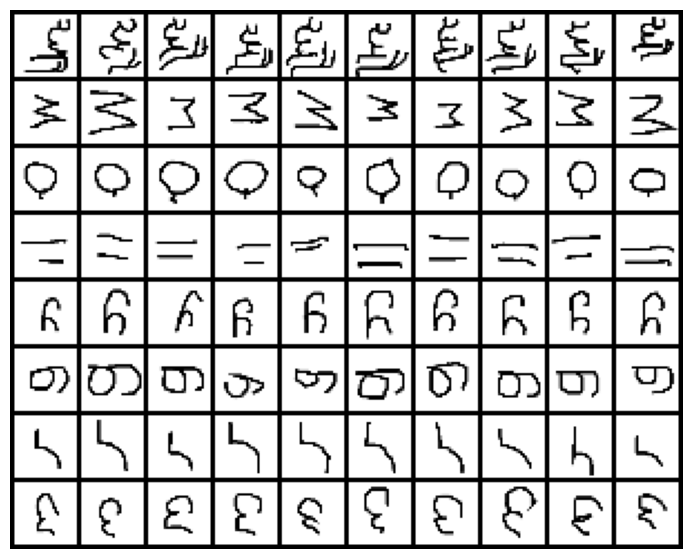

In [30]:
sample_example = extract_sample(8, 5, 5, trainx_meta, trainy_ids)
display_sample(sample_example['images'])

In [31]:
print(sample_example['images'].shape)

torch.Size([8, 10, 3, 28, 28])


## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [32]:
# pass your code
class EncoderCNN(nn.Module):
    def __init__(self, x_dim=(3, 28, 28), hid_dim=64, z_dim=64):
        super(EncoderCNN, self).__init__()
        self.x_dim_channels = x_dim[0]
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.encoder = nn.Sequential(
            conv_block(self.x_dim_channels, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
            nn.Flatten()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        return x

# Test encoder
test_encoder = EncoderCNN().to(device)
dummy_input = torch.randn(10, 3, 28, 28).to(device) # Batch of 10 images
output_dummy = test_encoder(dummy_input)
print(f"Encoder output shape: {output_dummy.shape}") # Should be (10, 64)
assert output_dummy.shape == (10, 64)


Encoder output shape: torch.Size([10, 64])


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [38]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.to(device)

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (dict): A dictionary containing:
                'images' (torch.Tensor): shape (n_way, n_support+n_query, C, H, W) on device
                'n_way' (int)
                'n_support' (int)
                'n_query' (int)
        Returns:
            tuple: (loss_val, metrics_dict)
                   loss_val (torch.Tensor): scalar loss
                   metrics_dict (dict):_ {'loss': float, 'acc': float, 'y_hat': torch.Tensor}
        """
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        
        x = sample_images.view(n_way * (n_support + n_query), 
                               *sample_images.shape[2:])
        
        z = self.encoder(x)
        z_dim = z.size(-1)
        
        z_proto = z.view(n_way, n_support + n_query, z_dim)
        
        # z_support: (n_way, n_support, z_dim)
        # z_query: (n_way, n_query, z_dim)
        z_support = z_proto[:, :n_support]
        z_query = z_proto[:, n_support:]
        
        # prototypes: (n_way, z_dim)
        prototypes = z_support.mean(dim=1)
        
        z_query_flat = z_query.reshape(n_way * n_query, z_dim)
        
        # dists: (n_way * n_query, n_way)
        dists = torch.cdist(z_query_flat, prototypes, p=2)

        # log_p_y: (n_way * n_query, n_way)
        log_p_y = F.log_softmax(-dists, dim=1)

        # target_inds: (n_way * n_query)
        target_inds = torch.arange(0, n_way, device=device).repeat_interleave(n_query)
        
        # loss_val = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()
        loss_val = -log_p_y.gather(1, target_inds.unsqueeze(1)).squeeze().mean()

        # accuracy
        _, y_hat = log_p_y.max(1)
        acc_val = (y_hat == target_inds).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat # (n_way * n_query)
            }


In [39]:
def load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = EncoderCNN(x_dim=x_dim, hid_dim=hid_dim, z_dim=z_dim)
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [40]:
LOG_DIR = 'runs/protonet_omniglot'
# if os.path.exists(LOG_DIR):
#     shutil.rmtree(LOG_DIR)
writer = SummaryWriter(LOG_DIR)

In [41]:
def train(model, optimizer, train_x_meta, train_y_ids, n_way, n_support, n_query, max_epoch, epoch_size, val_x_meta=None, val_y_ids=None, val_epoch_size=None):
    """
    Trains the protonet
    Args:
      model, optimizer
      train_x_meta (np.array): (path, rot_angle) tuples for training
      train_y_ids (np.array): integer labels for training
      n_way, n_support, n_query
      max_epoch, epoch_size
      val_x_meta, val_y_ids, val_epoch_size: Optional validation data
    """
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    
    for epoch in range(max_epoch):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        pbar_train = tqdm(range(epoch_size), desc=f"Epoch {epoch + 1}/{max_epoch} train")

        for episode_idx in pbar_train:
            sample = extract_sample(n_way, n_support, n_query, train_x_meta, train_y_ids)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            loss.backward()
            optimizer.step()
            
            running_loss += output['loss']
            running_acc += output['acc']
            
            if (episode_idx + 1) % 100 == 0:
                 pbar_train.set_postfix(loss=running_loss / (episode_idx + 1), acc=running_acc / (episode_idx + 1))
        
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f'Epoch {epoch+1}/{max_epoch} -- Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}')
        
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        writer.add_scalar('LearningRate', scheduler.get_last_lr()[0], epoch)

        if val_x_meta is not None and val_y_ids is not None and val_epoch_size is not None:
            model.eval()
            val_running_loss = 0.0
            val_running_acc = 0.0
            pbar_val = tqdm(range(val_epoch_size), desc=f"Epoch {epoch + 1}/{max_epoch} val")

            with torch.no_grad():
                for _ in pbar_val:
                    sample = extract_sample(n_way, n_support, n_query, val_x_meta, val_y_ids)
                    loss, output = model.set_forward_loss(sample)
                    val_running_loss += output['loss']
                    val_running_acc += output['acc']
            
            val_epoch_loss = val_running_loss / val_epoch_size
            val_epoch_acc = val_running_acc / val_epoch_size
            print(f'Epoch {epoch+1}/{max_epoch} -- Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
            writer.add_scalar('Loss/val', val_epoch_loss, epoch)
            writer.add_scalar('Accuracy/val', val_epoch_acc, epoch)

        scheduler.step()
    
    writer.close()
    print("Training complete.")


In [42]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

N_WAY_TRAIN = 60      # classes in a training episode
N_SUPPORT_TRAIN = 5   # support examples per class in training
N_QUERY_TRAIN = 5     # query examples per class in training

N_WAY_VAL = 20
N_SUPPORT_VAL = 5
N_QUERY_VAL = 5


MAX_EPOCH = 10
EPOCH_SIZE_TRAIN = 1000 # episodes per epoch for training
EPOCH_SIZE_VAL = 100 # episodes for validation

In [43]:
%%time
train(model, optimizer, trainx_meta, trainy_ids, 
      N_WAY_TRAIN, N_SUPPORT_TRAIN, N_QUERY_TRAIN, 
      MAX_EPOCH, EPOCH_SIZE_TRAIN,
      val_x_meta=testx_meta, val_y_ids=testy_ids,
      val_epoch_size=EPOCH_SIZE_VAL)

Epoch 1/10 -- Train Loss: 0.1863 Train Acc: 0.9604














































































































































































































Epoch 1/10 val: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


Epoch 1/10 -- Val Loss: 0.1442 Val Acc: 0.9654


Epoch 2/10 -- Train Loss: 0.0619 Train Acc: 0.9835














































































































































































































Epoch 2/10 val: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


Epoch 2/10 -- Val Loss: 0.1257 Val Acc: 0.9689


Epoch 3/10 -- Train Loss: 0.0481 Train Acc: 0.9859














































































































































































































Epoch 3/10 val: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


Epoch 3/10 -- Val Loss: 0.1080 Val Acc: 0.9724


Epoch 4/10 -- Train Loss: 0.0407 Train Acc: 0.9881














































































































































































































Epoch 4/10 val: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Epoch 4/10 -- Val Loss: 0.1030 Val Acc: 0.9743


Epoch 5/10 -- Train Loss: 0.0375 Train Acc: 0.9886














































































































































































































Epoch 5/10 val: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


Epoch 5/10 -- Val Loss: 0.1057 Val Acc: 0.9721


Epoch 6/10 -- Train Loss: 0.0359 Train Acc: 0.9891














































































































































































































Epoch 6/10 val: 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


Epoch 6/10 -- Val Loss: 0.0988 Val Acc: 0.9745


Epoch 7/10 -- Train Loss: 0.0349 Train Acc: 0.9894














































































































































































































Epoch 7/10 val: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


Epoch 7/10 -- Val Loss: 0.0950 Val Acc: 0.9747


Epoch 8/10 -- Train Loss: 0.0348 Train Acc: 0.9892














































































































































































































Epoch 8/10 val: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


Epoch 8/10 -- Val Loss: 0.1001 Val Acc: 0.9735


Epoch 9/10 -- Train Loss: 0.0347 Train Acc: 0.9894














































































































































































































Epoch 9/10 val: 100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


Epoch 9/10 -- Val Loss: 0.1024 Val Acc: 0.9740


Epoch 10/10 -- Train Loss: 0.0339 Train Acc: 0.9897














































































































































































































Epoch 10/10 val: 100%|██████████| 100/100 [00:07<00:00, 14.17it/s]

Epoch 10/10 -- Val Loss: 0.0958 Val Acc: 0.9744
Training complete.
CPU times: user 13min 24s, sys: 1min 22s, total: 14min 47s
Wall time: 14min 45s


In [44]:
MODEL_SAVE_PATH = "protonet_omniglot.pt"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to protonet_omniglot.pt


## Test

In [47]:
def test(model, test_x_meta, test_y_ids, n_way, n_support, n_query, test_episode_count):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x_meta (np.array): (path, rot_angle) for testing
      test_y_ids (np.array): integer labels for testing
      n_way, n_support, n_query
      test_episode_count (int): number of episodes to test on
    """
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    running_acc = 0.0
    
    pbar_test = tqdm(range(test_episode_count), desc="Testing")


    with torch.no_grad(): # Crucial for testing
        for _ in pbar_test:
            sample = extract_sample(n_way, n_support, n_query, test_x_meta, test_y_ids)
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            pbar_test.set_postfix(loss=running_loss / (pbar_test.n + 1), acc=running_acc / (pbar_test.n + 1))

            
    avg_loss = running_loss / test_episode_count
    avg_acc = running_acc / test_episode_count
    print(f'Test results -- Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc


In [48]:
# 5-way, 1-shot
# 5-way, 5-shot
# 20-way, 1-shot
# 20-way, 5-shot

test_configs = [
    {"name": "5-way, 1-shot", "n_way": 5, "n_support": 1, "n_query": 15},
    {"name": "5-way, 5-shot", "n_way": 5, "n_support": 5, "n_query": 15},
    {"name": "20-way, 1-shot", "n_way": 20, "n_support": 1, "n_query": 15},
    {"name": "20-way, 5-shot", "n_way": 20, "n_support": 5, "n_query": 15},
]

TEST_EPISODE_COUNT = 1000
# n_way = 5
# n_support = 5
# n_query = 5

# test_x = testx
# test_y = testy

# test_episode = 1000
model_loaded = load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64).to(device)
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
print(f"Model loaded from {MODEL_SAVE_PATH}")

Model loaded from protonet_omniglot.pt


In [49]:
results_table = {}
for config in test_configs:
    print(f"\nTesting: {config['name']}")
    avg_loss, avg_acc = test(model_loaded, testx_meta, testy_ids, 
                             config['n_way'], config['n_support'], config['n_query'], 
                             TEST_EPISODE_COUNT)
    results_table[config['name']] = {"loss": avg_loss, "accuracy": avg_acc}

print("\n--- Test Results Summary ---")
for name, res in results_table.items():
    print(f"{name}: Accuracy = {res['accuracy']:.4f} (Loss = {res['loss']:.4f})")



Testing: 5-way, 1-shot


Test results -- Loss: 0.0494 Acc: 0.9845

Testing: 5-way, 5-shot


Test results -- Loss: 0.0142 Acc: 0.9960

Testing: 20-way, 1-shot


Test results -- Loss: 0.1553 Acc: 0.9534

Testing: 20-way, 5-shot


Test results -- Loss: 0.0432 Acc: 0.9882

--- Test Results Summary ---
5-way, 1-shot: Accuracy = 0.9845 (Loss = 0.0494)
5-way, 5-shot: Accuracy = 0.9960 (Loss = 0.0142)
20-way, 1-shot: Accuracy = 0.9534 (Loss = 0.1553)
20-way, 5-shot: Accuracy = 0.9882 (Loss = 0.0432)


## Test on specific example

Sample for visualization:


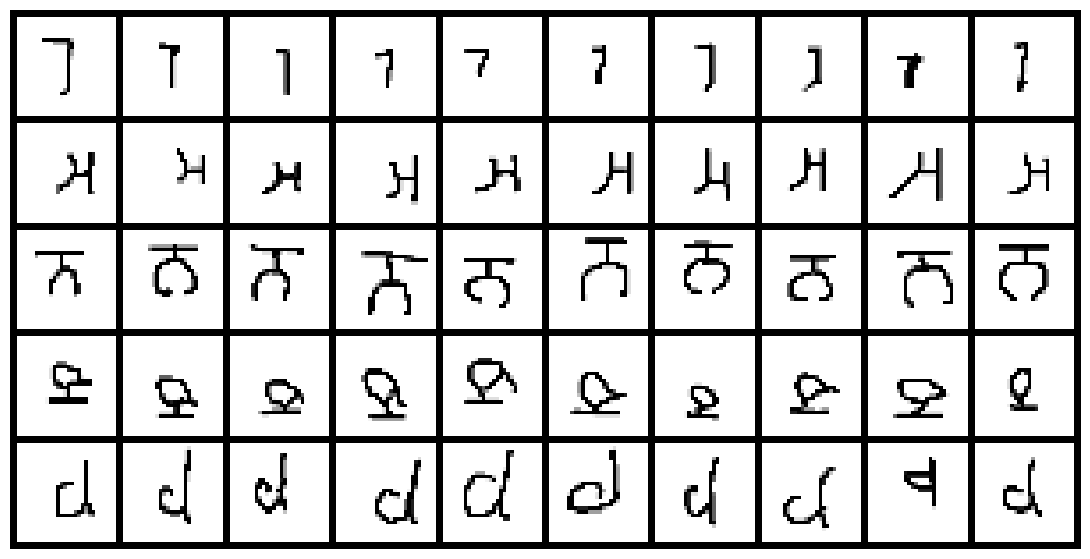

In [50]:
N_WAY_VIS = 5
N_SUPPORT_VIS = 5
N_QUERY_VIS = 5

my_sample = extract_sample(N_WAY_VIS, N_SUPPORT_VIS, N_QUERY_VIS, testx_meta, testy_ids)
print("Sample for visualization:")
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [58]:
# pass your code
def visualize_predictions(model, sample_dict):
    model.eval()
    with torch.no_grad():
        loss, output = model.set_forward_loss(sample_dict)

    images_tensor = sample_dict['images'] # (n_way, n_total_shot, C, H, W)
    n_way = sample_dict['n_way']
    n_support = sample_dict['n_support']
    n_query = sample_dict['n_query']
    
    predictions_flat = output['y_hat'] # (n_way * n_query)
    
    support_images = images_tensor[:, :n_support].cpu()
    query_images = images_tensor[:, n_support:].cpu() # (n_way, n_query, C, H, W)
    
    true_labels_flat = torch.arange(0, n_way).repeat_interleave(n_query) # (n_way * n_query)

    predictions = predictions_flat.view(n_way, n_query)
    true_labels = true_labels_flat.view(n_way, n_query)

    print(f"Overall Accuracy on this sample: {output['acc']:.4f}")

    fig, axes = plt.subplots(n_way, n_support + n_query, figsize=(n_support + n_query + 3, n_way + 1))
    fig.suptitle("Prototypical Network Predictions (Support | Query)", fontsize=16)

    for i in range(n_way): # classes
        for j in range(n_support):
            ax = axes[i, j]
            img = support_images[i, j].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class {i} (Support)", fontsize=8, loc='left', y=0, pad=-10, backgroundcolor='lightgray')
            if i == 0 and j == n_support // 2:
                 axes[i,j].set_title("SUPPORT SET", fontsize=10, loc='center', y=1.2)

        for k in range(n_query):
            ax_idx = n_support + k
            ax = axes[i, ax_idx]
            img = query_images[i, k].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
            
            true_cls = true_labels[i, k].item()
            pred_cls = predictions[i, k].item()
            
            title_color = 'green' if true_cls == pred_cls else 'red'
            ax.set_title(f"GT:{true_cls}, P:{pred_cls}", color=title_color, fontsize=8, loc='center', y=0, pad=-10)
            if i == 0 and k == n_query // 2:
                 axes[i,ax_idx].set_title("QUERY SET", fontsize=10, loc='center', y=1.2)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    report_predictions = []
    query_images_flat = query_images.reshape(n_way * n_query, *query_images.shape[2:])
    
    for idx in range(min(10, n_way * n_query)):
        img = query_images_flat[idx].permute(1,2,0).numpy()
        true_label = true_labels_flat[idx].item()
        pred_label = predictions_flat[idx].item()
        report_predictions.append({
            "image_array": (img * 255).astype(np.uint8),
            "true_label": true_label,
            "predicted_label": pred_label
        })
    return report_predictions


Overall Accuracy on this sample: 1.0000


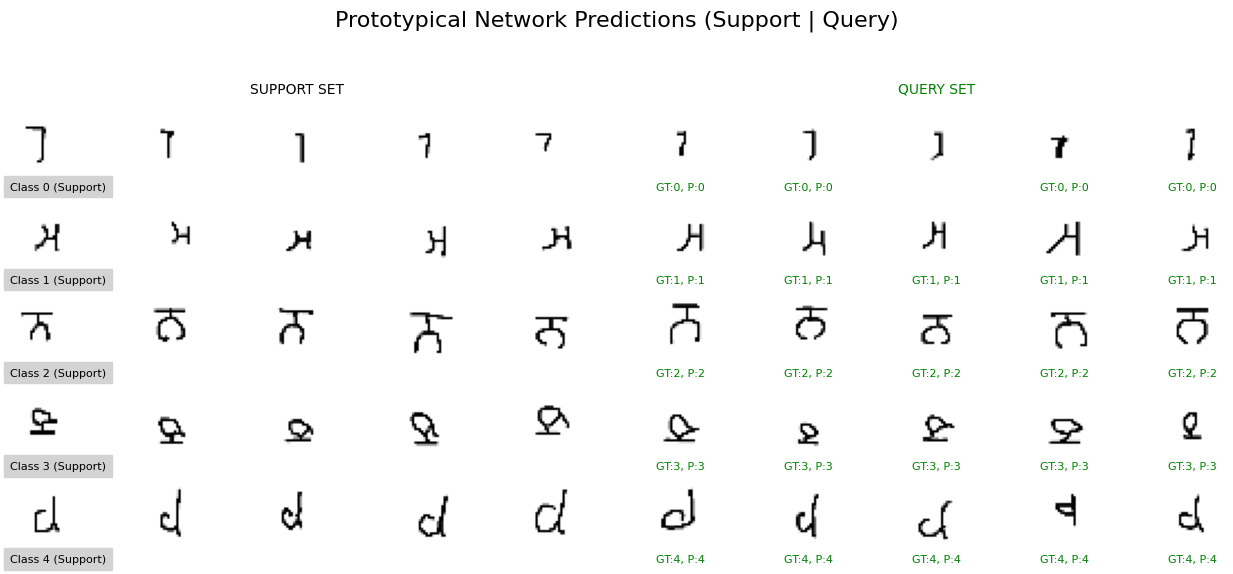

In [59]:
predictions_for_report = visualize_predictions(model_loaded, my_sample)

In [61]:
PREDICTIONS_DIR = "test_predictions_protonet"
if os.path.exists(PREDICTIONS_DIR):
    shutil.rmtree(PREDICTIONS_DIR)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

with open(os.path.join(PREDICTIONS_DIR, "predictions.txt"), "w") as f_report:
    f_report.write("Index | True Label | Predicted Label | Image File\n")
    for i, item in enumerate(predictions_for_report):
        img_filename = f"query_img_{i}_true{item['true_label']}_pred{item['predicted_label']}.png"
        cv2.imwrite(os.path.join(PREDICTIONS_DIR, img_filename), cv2.cvtColor(item['image_array'], cv2.COLOR_RGB2BGR))
        f_report.write(f"{i:5d} | {item['true_label']:10d} | {item['predicted_label']:15d} | {img_filename}\n")
print(f"Saved 10 prediction examples to {PREDICTIONS_DIR}")

Saved 10 prediction examples to test_predictions_protonet


# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды: 
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара



In [62]:
X_cifar_train_full, y_cifar_train_full, X_cifar_val_full, y_cifar_val_full, X_cifar_test_full, y_cifar_test_full = load_cifar10("../seminar/cifar_data", channels_last=True)

subset_fraction = 0.2
num_subset_samples = int(len(X_cifar_train_full) * subset_fraction)
X_cifar_train_simclr = X_cifar_train_full[:num_subset_samples]
y_cifar_train_simclr = y_cifar_train_full[:num_subset_samples]

print(f"Using {len(X_cifar_train_simclr)} samples for SimCLR pre-training.")

Using 8000 samples for SimCLR pre-training.


In [64]:
class CLDataset(Dataset):
    def __init__(self, x_data, y_data, transform_augment=None):
        self.x_data = x_data
        self.y_data = y_data
        assert transform_augment is not None, 'set transform_augment'
        self.transform_augment = transform_augment

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, item):
        image = self.x_data[item]
        image = (image * 255).astype(np.uint8)
        # label = self.y_data[item] # Not used in SimCLR loss

        x1 = self.transform_augment(image=image)['image'] # C,H,W
        x2 = self.transform_augment(image=image)['image']
        return x1, x2 #, label

In [66]:
CIFAR10_MEAN = np.array([0.4915541, 0.4823643, 0.4466405])
CIFAR10_STD = np.array([0.24702361, 0.24335612, 0.26146203])

In [69]:
simclr_transform = A.Compose([
    A.RandomResizedCrop(size=(32, 32), scale=(0.2, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ToTensorV2()
])

In [70]:
simclr_dataset = CLDataset(X_cifar_train_simclr, y_cifar_train_simclr, transform_augment=simclr_transform)
simclr_loader = DataLoader(simclr_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [75]:
# SimCLR Model (ResNet18 encoder + Projection Head)
class ProjectionHead(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features)
        )
    def forward(self, x):
        return self.layers(x)

In [76]:
class SimCLRModel(nn.Module):
    def __init__(self, base_encoder_name='resnet18', projection_dim=128):
        super().__init__()
        if base_encoder_name == 'resnet18':
            self.encoder = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
            encoder_out_features = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        else:
            raise ValueError(f"Unsupported encoder: {base_encoder_name}")

        self.projection_head = ProjectionHead(encoder_out_features, encoder_out_features, projection_dim)

    def forward(self, x):
        h = self.encoder(x) 
        z = self.projection_head(h)
        return h, z

In [77]:
class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
        self.similarity_f = nn.CosineSimilarity(dim=-1)

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0) # (2*B, D)
        
        sim_matrix = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature # (2*B, 2*B)
        
        labels = torch.arange(2 * batch_size, device=z.device).roll(shifts=batch_size, dims=0)
        
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim_matrix.masked_fill_(mask, -float('inf'))
        
        loss = self.criterion(sim_matrix, labels)
        return loss

In [78]:
simclr_model = SimCLRModel().to(device)
simclr_criterion = SimCLRLoss(temperature=0.1).to(device)
simclr_optimizer = optim.AdamW(simclr_model.parameters(), lr=3e-4, weight_decay=1e-4)

SIMCLR_EPOCHS = 10
SIMCLR_LOG_DIR = 'runs/simclr_cifar10'
if os.path.exists(SIMCLR_LOG_DIR): shutil.rmtree(SIMCLR_LOG_DIR)
simclr_writer = SummaryWriter(SIMCLR_LOG_DIR)

print("Starting SimCLR pre-training...")
for epoch in range(SIMCLR_EPOCHS):
    simclr_model.train()
    total_loss = 0
    pbar_simclr = tqdm(simclr_loader, desc=f"SimCLR Epoch {epoch+1}/{SIMCLR_EPOCHS}")


    for x_i, x_j in pbar_simclr:
        x_i, x_j = x_i.to(device), x_j.to(device)
        
        simclr_optimizer.zero_grad()
        _, z_i = simclr_model(x_i)
        _, z_j = simclr_model(x_j)
        
        loss = simclr_criterion(z_i, z_j)
        loss.backward()
        simclr_optimizer.step()
        
        total_loss += loss.item()
        pbar_simclr.set_postfix(loss=loss.item())
        
    avg_loss = total_loss / len(simclr_loader)
    print(f"SimCLR Epoch {epoch+1}/{SIMCLR_EPOCHS}, Avg Loss: {avg_loss:.4f}")
    simclr_writer.add_scalar("Loss/SimCLR_train", avg_loss, epoch)

simclr_writer.close()
SIMCLR_ENCODER_SAVE_PATH = "simclr_encoder_cifar10.pt"
torch.save(simclr_model.encoder.state_dict(), SIMCLR_ENCODER_SAVE_PATH)
print(f"SimCLR pre-trained encoder saved to {SIMCLR_ENCODER_SAVE_PATH}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/borovets.av/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s] 


Starting SimCLR pre-training...


SimCLR Epoch 1/10: 100%|██████████| 62/62 [00:02<00:00, 21.14it/s, loss=3.84]


SimCLR Epoch 1/10, Avg Loss: 4.1682


SimCLR Epoch 2/10: 100%|██████████| 62/62 [00:02<00:00, 22.95it/s, loss=3.01]


SimCLR Epoch 2/10, Avg Loss: 3.1855


SimCLR Epoch 3/10: 100%|██████████| 62/62 [00:02<00:00, 22.58it/s, loss=2.72]


SimCLR Epoch 3/10, Avg Loss: 2.7387


SimCLR Epoch 4/10: 100%|██████████| 62/62 [00:02<00:00, 22.62it/s, loss=2.45]


SimCLR Epoch 4/10, Avg Loss: 2.4446


SimCLR Epoch 5/10: 100%|██████████| 62/62 [00:02<00:00, 22.87it/s, loss=2.38]


SimCLR Epoch 5/10, Avg Loss: 2.2456


SimCLR Epoch 6/10: 100%|██████████| 62/62 [00:02<00:00, 22.37it/s, loss=2.47]


SimCLR Epoch 6/10, Avg Loss: 2.1221


SimCLR Epoch 7/10: 100%|██████████| 62/62 [00:02<00:00, 22.15it/s, loss=2.43]


SimCLR Epoch 7/10, Avg Loss: 2.0323


SimCLR Epoch 8/10: 100%|██████████| 62/62 [00:02<00:00, 22.40it/s, loss=2.18]


SimCLR Epoch 8/10, Avg Loss: 1.9454


SimCLR Epoch 9/10: 100%|██████████| 62/62 [00:02<00:00, 22.15it/s, loss=2.16]


SimCLR Epoch 9/10, Avg Loss: 1.8812


SimCLR Epoch 10/10: 100%|██████████| 62/62 [00:02<00:00, 21.90it/s, loss=2.09]


SimCLR Epoch 10/10, Avg Loss: 1.8358
SimCLR pre-trained encoder saved to simclr_encoder_cifar10.pt


In [90]:
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        # dummy_input = torch.randn(1, 3, 32, 32).to(device)
        dummy_input = torch.randn(2, 3, 32, 32).to(device)
        encoder_out_dim = self.encoder(dummy_input).shape[-1]
        
        self.classifier = nn.Linear(encoder_out_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier(features)


In [91]:
X_downstream_train, X_downstream_val, y_downstream_train, y_downstream_val = train_test_split(
    X_cifar_test_full, y_cifar_test_full, test_size=0.3, random_state=42, stratify=y_cifar_test_full
)
print(f"Downstream train size: {len(X_downstream_train)}, Val size: {len(X_downstream_val)}")

downstream_transform_train = A.Compose([
    A.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ToTensorV2()
])
downstream_transform_val = A.Compose([
    A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ToTensorV2()
])


Downstream train size: 7000, Val size: 3000


In [92]:
class CIFARClassificationDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = (self.images[idx] * 255).astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

In [93]:
ds_train_dataset = CIFARClassificationDataset(X_downstream_train, y_downstream_train, transform=downstream_transform_train)
ds_val_dataset = CIFARClassificationDataset(X_downstream_val, y_downstream_val, transform=downstream_transform_val)

In [94]:
ds_train_loader = DataLoader(ds_train_dataset, batch_size=64, shuffle=True, num_workers=2)
ds_val_loader = DataLoader(ds_val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [101]:
def train_classifier(classifier_model, train_loader, val_loader, epochs, lr, model_name="Classifier"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=lr)
    
    CLASSIFIER_LOG_DIR = f'runs/{model_name}_cifar10'
    if os.path.exists(CLASSIFIER_LOG_DIR): shutil.rmtree(CLASSIFIER_LOG_DIR)
    cls_writer = SummaryWriter(CLASSIFIER_LOG_DIR)

    print(f"Starting training for {model_name}...")
    best_val_acc = 0.0

    for epoch in range(epochs):
        classifier_model.train()
        epoch_train_loss = 0
        pbar_cls_train = tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs} Train")

        for images, labels in pbar_cls_train:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = classifier_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            pbar_cls_train.set_postfix(loss=loss.item())
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        cls_writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        
        # Validation
        classifier_model.eval()
        epoch_val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            pbar_cls_val = tqdm(val_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs} Val")
            for images, labels in pbar_cls_val:
                images, labels = images.to(device), labels.to(device)
                labels = labels.long()
                outputs = classifier_model(images)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        
        print(f"{model_name} Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        cls_writer.add_scalar("Loss/Val", avg_val_loss, epoch)
        cls_writer.add_scalar("Accuracy/Val", val_acc, epoch)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(classifier_model.state_dict(), f"{model_name}_best.pt")
    
    cls_writer.close()
    print(f"Finished training for {model_name}. Best Val Acc: {best_val_acc:.4f}")
    return best_val_acc

In [102]:
simclr_pretrained_encoder = torchvision.models.resnet18()
simclr_pretrained_encoder.fc = nn.Identity()
simclr_pretrained_encoder.load_state_dict(torch.load(SIMCLR_ENCODER_SAVE_PATH, map_location=device))
simclr_pretrained_encoder = simclr_pretrained_encoder.to(device)

In [103]:
classifier_with_simclr = DownstreamClassifier(encoder=simclr_pretrained_encoder).to(device)
acc_with_simclr = train_classifier(classifier_with_simclr, ds_train_loader, ds_val_loader, epochs=10, lr=1e-3, model_name="Classifier_With_SimCLR")

Starting training for Classifier_With_SimCLR...


Classifier_With_SimCLR Epoch 1/10 Val:  85%|████████▌ | 40/47 [00:00<00:00, 150.46it/s]

Classifier_With_SimCLR Epoch 1/10 Val: 100%|██████████| 47/47 [00:00<00:00, 108.37it/s]


Classifier_With_SimCLR Epoch 1/10 - Train Loss: 1.3765, Val Loss: 1.1250, Val Acc: 0.5960


Classifier_With_SimCLR Epoch 2/10 Val: 100%|██████████| 47/47 [00:00<00:00, 123.73it/s]


Classifier_With_SimCLR Epoch 2/10 - Train Loss: 1.1376, Val Loss: 1.1013, Val Acc: 0.6070


Classifier_With_SimCLR Epoch 3/10 Val: 100%|██████████| 47/47 [00:00<00:00, 119.49it/s]


Classifier_With_SimCLR Epoch 3/10 - Train Loss: 1.1035, Val Loss: 1.0804, Val Acc: 0.6157


Classifier_With_SimCLR Epoch 4/10 Val: 100%|██████████| 47/47 [00:00<00:00, 123.62it/s]


Classifier_With_SimCLR Epoch 4/10 - Train Loss: 1.0719, Val Loss: 1.0966, Val Acc: 0.6120


Classifier_With_SimCLR Epoch 5/10 Val: 100%|██████████| 47/47 [00:00<00:00, 121.66it/s]


Classifier_With_SimCLR Epoch 5/10 - Train Loss: 1.0534, Val Loss: 1.0711, Val Acc: 0.6200


Classifier_With_SimCLR Epoch 6/10 Val: 100%|██████████| 47/47 [00:00<00:00, 120.43it/s]


Classifier_With_SimCLR Epoch 6/10 - Train Loss: 1.0528, Val Loss: 1.0875, Val Acc: 0.6210


Classifier_With_SimCLR Epoch 7/10 Val: 100%|██████████| 47/47 [00:00<00:00, 107.34it/s]


Classifier_With_SimCLR Epoch 7/10 - Train Loss: 1.0316, Val Loss: 1.0408, Val Acc: 0.6267


Classifier_With_SimCLR Epoch 8/10 Val: 100%|██████████| 47/47 [00:00<00:00, 119.67it/s]


Classifier_With_SimCLR Epoch 8/10 - Train Loss: 1.0232, Val Loss: 1.0507, Val Acc: 0.6280


Classifier_With_SimCLR Epoch 9/10 Val: 100%|██████████| 47/47 [00:00<00:00, 124.72it/s]


Classifier_With_SimCLR Epoch 9/10 - Train Loss: 1.0157, Val Loss: 1.0526, Val Acc: 0.6273


Classifier_With_SimCLR Epoch 10/10 Val: 100%|██████████| 47/47 [00:00<00:00, 115.20it/s]


Classifier_With_SimCLR Epoch 10/10 - Train Loss: 1.0112, Val Loss: 1.0463, Val Acc: 0.6330
Finished training for Classifier_With_SimCLR. Best Val Acc: 0.6330


## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [104]:
scratch_encoder = torchvision.models.resnet18(weights=None) # Random weights
scratch_encoder.fc = nn.Identity()
scratch_encoder = scratch_encoder.to(device)

In [105]:
classifier_from_scratch_frozen_encoder = DownstreamClassifier(encoder=scratch_encoder.to(device)).to(device)
acc_from_scratch_frozen = train_classifier(classifier_from_scratch_frozen_encoder, ds_train_loader, ds_val_loader, epochs=10, lr=1e-3, model_name="Classifier_ScratchFrozen")

Starting training for Classifier_ScratchFrozen...


Classifier_ScratchFrozen Epoch 1/10 Val: 100%|██████████| 47/47 [00:00<00:00, 103.00it/s]


Classifier_ScratchFrozen Epoch 1/10 - Train Loss: 2.2071, Val Loss: 2.0910, Val Acc: 0.2403


Classifier_ScratchFrozen Epoch 2/10 Val: 100%|██████████| 47/47 [00:00<00:00, 112.62it/s]


Classifier_ScratchFrozen Epoch 2/10 - Train Loss: 2.0598, Val Loss: 2.0269, Val Acc: 0.2653


Classifier_ScratchFrozen Epoch 3/10 Val: 100%|██████████| 47/47 [00:00<00:00, 130.32it/s]


Classifier_ScratchFrozen Epoch 3/10 - Train Loss: 2.0061, Val Loss: 2.0540, Val Acc: 0.2657


Classifier_ScratchFrozen Epoch 4/10 Val: 100%|██████████| 47/47 [00:00<00:00, 107.70it/s]


Classifier_ScratchFrozen Epoch 4/10 - Train Loss: 1.9521, Val Loss: 1.9825, Val Acc: 0.2820


Classifier_ScratchFrozen Epoch 5/10 Val: 100%|██████████| 47/47 [00:00<00:00, 118.72it/s]


Classifier_ScratchFrozen Epoch 5/10 - Train Loss: 1.9578, Val Loss: 1.9706, Val Acc: 0.2890


Classifier_ScratchFrozen Epoch 6/10 Val: 100%|██████████| 47/47 [00:00<00:00, 109.95it/s]


Classifier_ScratchFrozen Epoch 6/10 - Train Loss: 1.9456, Val Loss: 1.9612, Val Acc: 0.2917


Classifier_ScratchFrozen Epoch 7/10 Val: 100%|██████████| 47/47 [00:00<00:00, 118.04it/s]


Classifier_ScratchFrozen Epoch 7/10 - Train Loss: 1.9315, Val Loss: 1.9699, Val Acc: 0.2843


Classifier_ScratchFrozen Epoch 8/10 Val: 100%|██████████| 47/47 [00:00<00:00, 122.45it/s]


Classifier_ScratchFrozen Epoch 8/10 - Train Loss: 1.9190, Val Loss: 1.9666, Val Acc: 0.2887


Classifier_ScratchFrozen Epoch 9/10 Val: 100%|██████████| 47/47 [00:00<00:00, 107.96it/s]


Classifier_ScratchFrozen Epoch 9/10 - Train Loss: 1.9141, Val Loss: 1.9687, Val Acc: 0.2877


Classifier_ScratchFrozen Epoch 10/10 Val: 100%|██████████| 47/47 [00:00<00:00, 107.52it/s]

Classifier_ScratchFrozen Epoch 10/10 - Train Loss: 1.9253, Val Loss: 1.9676, Val Acc: 0.2900
Finished training for Classifier_ScratchFrozen. Best Val Acc: 0.2917


In [106]:
scratch_encoder_trainable = torchvision.models.resnet18(weights=None).to(device) # Random weights
scratch_encoder_trainable.fc = nn.Identity()

In [110]:
class FullyTrainableClassifier(nn.Module):
    def __init__(self, base_encoder, num_classes=10):
        super().__init__()
        self.encoder = base_encoder
        # dummy_input = torch.randn(1, 3, 32, 32).to(device)
        dummy_input = torch.randn(2, 3, 32, 32).to(device)
        encoder_out_dim = self.encoder(dummy_input).shape[-1]
        self.classifier = nn.Linear(encoder_out_dim, num_classes)
    
    def forward(self,x):
        features = self.encoder(x)
        return self.classifier(features)


In [111]:
classifier_from_scratch_full_training = FullyTrainableClassifier(base_encoder=scratch_encoder_trainable).to(device)
acc_from_scratch_full = train_classifier(classifier_from_scratch_full_training, ds_train_loader, ds_val_loader, epochs=10, lr=1e-3, model_name="Classifier_ScratchFull")

Starting training for Classifier_ScratchFull...


Classifier_ScratchFull Epoch 1/10 Train:   1%|          | 1/110 [00:00<00:16,  6.52it/s, loss=2.33]

Classifier_ScratchFull Epoch 1/10 Val: 100%|██████████| 47/47 [00:00<00:00, 126.87it/s]


Classifier_ScratchFull Epoch 1/10 - Train Loss: 1.8517, Val Loss: 1.5967, Val Acc: 0.3980


Classifier_ScratchFull Epoch 2/10 Val: 100%|██████████| 47/47 [00:00<00:00, 123.60it/s]


Classifier_ScratchFull Epoch 2/10 - Train Loss: 1.5705, Val Loss: 1.5370, Val Acc: 0.4363


Classifier_ScratchFull Epoch 3/10 Val: 100%|██████████| 47/47 [00:00<00:00, 129.24it/s]


Classifier_ScratchFull Epoch 3/10 - Train Loss: 1.4522, Val Loss: 1.5796, Val Acc: 0.4417


Classifier_ScratchFull Epoch 4/10 Val: 100%|██████████| 47/47 [00:00<00:00, 126.39it/s]


Classifier_ScratchFull Epoch 4/10 - Train Loss: 1.3581, Val Loss: 1.4250, Val Acc: 0.5063


Classifier_ScratchFull Epoch 5/10 Val: 100%|██████████| 47/47 [00:00<00:00, 110.84it/s]


Classifier_ScratchFull Epoch 5/10 - Train Loss: 1.2680, Val Loss: 1.3233, Val Acc: 0.5353


Classifier_ScratchFull Epoch 6/10 Val: 100%|██████████| 47/47 [00:00<00:00, 122.66it/s]


Classifier_ScratchFull Epoch 6/10 - Train Loss: 1.2140, Val Loss: 1.4029, Val Acc: 0.5233


Classifier_ScratchFull Epoch 7/10 Val: 100%|██████████| 47/47 [00:00<00:00, 111.24it/s]


Classifier_ScratchFull Epoch 7/10 - Train Loss: 1.1436, Val Loss: 1.2731, Val Acc: 0.5547


Classifier_ScratchFull Epoch 8/10 Val: 100%|██████████| 47/47 [00:00<00:00, 118.25it/s]


Classifier_ScratchFull Epoch 8/10 - Train Loss: 1.0707, Val Loss: 1.3102, Val Acc: 0.5517


Classifier_ScratchFull Epoch 9/10 Val: 100%|██████████| 47/47 [00:00<00:00, 108.04it/s]


Classifier_ScratchFull Epoch 9/10 - Train Loss: 1.0068, Val Loss: 1.1921, Val Acc: 0.5843


Classifier_ScratchFull Epoch 10/10 Val: 100%|██████████| 47/47 [00:00<00:00, 113.23it/s]


Classifier_ScratchFull Epoch 10/10 - Train Loss: 0.9650, Val Loss: 1.1601, Val Acc: 0.5953
Finished training for Classifier_ScratchFull. Best Val Acc: 0.5953


In [112]:
print("\n--- Downstream Task Comparison ---")
print(f"Accuracy with SimCLR pre-trained encoder (linear probe): {acc_with_simclr:.4f}")
print(f"Accuracy with Scratch encoder (random, frozen, linear probe): {acc_from_scratch_frozen:.4f}")
print(f"Accuracy with Scratch encoder (random, trained end-to-end): {acc_from_scratch_full:.4f}")


--- Downstream Task Comparison ---
Accuracy with SimCLR pre-trained encoder (linear probe): 0.6330
Accuracy with Scratch encoder (random, frozen, linear probe): 0.2917
Accuracy with Scratch encoder (random, trained end-to-end): 0.5953


In [113]:
imagenet_encoder = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).to(device)
imagenet_encoder.fc = nn.Identity()
classifier_with_imagenet = DownstreamClassifier(encoder=imagenet_encoder).to(device)
acc_with_imagenet = train_classifier(classifier_with_imagenet, ds_train_loader, ds_val_loader, epochs=10, lr=1e-3, model_name="Classifier_With_ImageNet")
print(f"Accuracy with ImageNet pre-trained encoder (linear probe): {acc_with_imagenet:.4f}")

Starting training for Classifier_With_ImageNet...


Classifier_With_ImageNet Epoch 1/10 Val: 100%|██████████| 47/47 [00:00<00:00, 108.22it/s]


Classifier_With_ImageNet Epoch 1/10 - Train Loss: 2.0493, Val Loss: 1.8161, Val Acc: 0.3723


Classifier_With_ImageNet Epoch 2/10 Val: 100%|██████████| 47/47 [00:00<00:00, 111.58it/s]


Classifier_With_ImageNet Epoch 2/10 - Train Loss: 1.7720, Val Loss: 1.7665, Val Acc: 0.3843


Classifier_With_ImageNet Epoch 3/10 Val: 100%|██████████| 47/47 [00:00<00:00, 115.11it/s]


Classifier_With_ImageNet Epoch 3/10 - Train Loss: 1.7128, Val Loss: 1.6992, Val Acc: 0.4050


Classifier_With_ImageNet Epoch 4/10 Val: 100%|██████████| 47/47 [00:00<00:00, 111.85it/s]


Classifier_With_ImageNet Epoch 4/10 - Train Loss: 1.6693, Val Loss: 1.6789, Val Acc: 0.4207


Classifier_With_ImageNet Epoch 5/10 Val: 100%|██████████| 47/47 [00:00<00:00, 126.28it/s]


Classifier_With_ImageNet Epoch 5/10 - Train Loss: 1.6564, Val Loss: 1.6535, Val Acc: 0.4263


Classifier_With_ImageNet Epoch 6/10 Val: 100%|██████████| 47/47 [00:00<00:00, 119.91it/s]


Classifier_With_ImageNet Epoch 6/10 - Train Loss: 1.6078, Val Loss: 1.6349, Val Acc: 0.4343


Classifier_With_ImageNet Epoch 7/10 Val: 100%|██████████| 47/47 [00:00<00:00, 116.63it/s]


Classifier_With_ImageNet Epoch 7/10 - Train Loss: 1.6295, Val Loss: 1.6118, Val Acc: 0.4343


Classifier_With_ImageNet Epoch 8/10 Val: 100%|██████████| 47/47 [00:00<00:00, 124.13it/s]


Classifier_With_ImageNet Epoch 8/10 - Train Loss: 1.6054, Val Loss: 1.6468, Val Acc: 0.4287


Classifier_With_ImageNet Epoch 9/10 Val: 100%|██████████| 47/47 [00:00<00:00, 115.24it/s]


Classifier_With_ImageNet Epoch 9/10 - Train Loss: 1.5879, Val Loss: 1.6323, Val Acc: 0.4347


Classifier_With_ImageNet Epoch 10/10 Val: 100%|██████████| 47/47 [00:00<00:00, 114.08it/s]

Classifier_With_ImageNet Epoch 10/10 - Train Loss: 1.5897, Val Loss: 1.6454, Val Acc: 0.4290
Finished training for Classifier_With_ImageNet. Best Val Acc: 0.4347
Accuracy with ImageNet pre-trained encoder (linear probe): 0.4347


In [114]:
print("\n--- FINAL ACCURACY SUMMARY ---")
print(f"1. SimCLR Pre-trained Encoder (Linear Probe): {acc_with_simclr:.4f}")
print(f"2. ImageNet Pre-trained Encoder (Linear Probe): {acc_with_imagenet:.4f}")
print(f"3. Scratch Encoder (Fully Trained End-to-End): {acc_from_scratch_full:.4f}")
print(f"4. Scratch Encoder (Random, Frozen, Linear Probe): {acc_from_scratch_frozen:.4f} (Expected to be low)")


--- FINAL ACCURACY SUMMARY ---
1. SimCLR Pre-trained Encoder (Linear Probe): 0.6330
2. ImageNet Pre-trained Encoder (Linear Probe): 0.4347
3. Scratch Encoder (Fully Trained End-to-End): 0.5953
4. Scratch Encoder (Random, Frozen, Linear Probe): 0.2917 (Expected to be low)
